### Machine Learning with Big Data
## Part 2: Convolutional Neural Networks

# 0.5 - Dropout

**Group:** MLBD_Deventer 4   
**Students:** Mathijs Pattipeilohy (512391), Emin Fikret (511275)

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

from joblib import load

2025-10-25 16:37:29.798636: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-25 16:37:29.847757: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-25 16:37:30.184679: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-25 16:37:32.075105: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
SEED = 42
EPOCHS = 10
BATCH  = 32 # default

tf.keras.utils.set_random_seed(SEED)

In [3]:
ARTIFACTS_DIR = "../artifacts"
MODEL_NAME = "cnn_dropout"

INPUT_FILE = os.path.join(ARTIFACTS_DIR, "images_tuple.joblib")

LOG_DIR   = os.path.join(ARTIFACTS_DIR, "logs", f"{MODEL_NAME}")
MODEL_FILE = os.path.join(ARTIFACTS_DIR, f"{MODEL_NAME}.keras")
CKPT_FILE  = os.path.join(ARTIFACTS_DIR, f"best_{MODEL_NAME}.keras")

In [4]:
(
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    classes
) = load(INPUT_FILE)

num_classes = len(classes)
print("Classes:", classes)
print("Train shape:", X_train.shape, y_train.shape)

Classes: ['az', 'dobro', 'estb', 'frbtb', 'ize', 'jatb', 'ljudie', 'nasb', 'sa', 'sta', 'ukb', 'vede']
Train shape: (900, 128, 128, 4) (900, 12)


### Recap

In the previous version, we added pooling layers to make the model faster and smaller.

The results showed good accuracy but still a visible gap between training and validation, which suggests mild overfitting.

## Model: Dropout

To reduce overfitting, we add dropout layers after each pooling layer and before the dense layer.

Dropout randomly disables a fraction of neurons during training, which prevents the model from memorizing the training data and helps it generalize better.

> **Note:** We did not experiment with increasing the number of layers because the models did not show signs of underfitting.

In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1:]),
    tf.keras.layers.Rescaling(1.0 / 255), # min-max scale rbg values

    tf.keras.layers.Conv2D(
        32, (3,3), 
        activation="relu",
        padding="same", # add zeros around the edges
    ), # learns low-level features, like edges
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.25), # low regularization
    
    tf.keras.layers.Conv2D(
        64, (3,3), 
        activation="relu",
        padding="same", # add zeros around the edges
    ), # learns higher-lever combinations, like shapes
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.25), # mid regularization
    
    tf.keras.layers.Flatten(), # turns 2d features into 1d vector
    tf.keras.layers.Dropout(0.5), # high regularization
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(), # variation of gradient descent
    loss=tf.keras.losses.CategoricalCrossentropy(),
    # we could have just used accuracy, 
    # it would have fallen back to categorical accuracy
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │       786,444 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 806,124 (3.08 MB)

 Trainable params: 806,124 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR),
    # Not included, because we cannot easily compare different models
    # if val_loss does not get better after 3 epochs, 
    # stop training and get the best model weights
    # tf.keras.callbacks.EarlyStopping(
    #     monitor="val_loss", patience=3, restore_best_weights=True
    # ),
    # save best model
    tf.keras.callbacks.ModelCheckpoint(
        CKPT_FILE, monitor="val_categorical_accuracy", save_best_only=True
    )
]

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    shuffle=True,
    validation_data=(X_val, y_val),
    # or we could have used "validation_set" param
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/10
29/29 - 9s - 317ms/step - categorical_accuracy: 0.4689 - loss: 1.8820 - val_categorical_accuracy: 0.8256 - val_loss: 0.5359
Epoch 2/10
29/29 - 8s - 268ms/step - categorical_accuracy: 0.8833 - loss: 0.3499 - val_categorical_accuracy: 0.8876 - val_loss: 0.3383
Epoch 3/10
29/29 - 8s - 278ms/step - categorical_accuracy: 0.9500 - loss: 0.1547 - val_categorical_accuracy: 0.8876 - val_loss: 0.2947
Epoch 4/10
29/29 - 9s - 299ms/step - categorical_accuracy: 0.9678 - loss: 0.1080 - val_categorical_accuracy: 0.8760 - val_loss: 0.3408
Epoch 5/10
29/29 - 9s - 311ms/step - categorical_accuracy: 0.9700 - loss: 0.0786 - val_categorical_accuracy: 0.8992 - val_loss: 0.3046
Epoch 6/10
29/29 - 9s - 320ms/step - categorical_accuracy: 0.9767 - loss: 0.0690 - val_categorical_accuracy: 0.9031 - val_loss: 0.3553
Epoch 7/10
29/29 - 9s - 323ms/step - categorical_accuracy: 0.9878 - loss: 0.0442 - val_categorical_accuracy: 0.9186 - val_loss: 0.2651
Epoch 8/10
29/29 - 9s - 320ms/step - categorical_accura

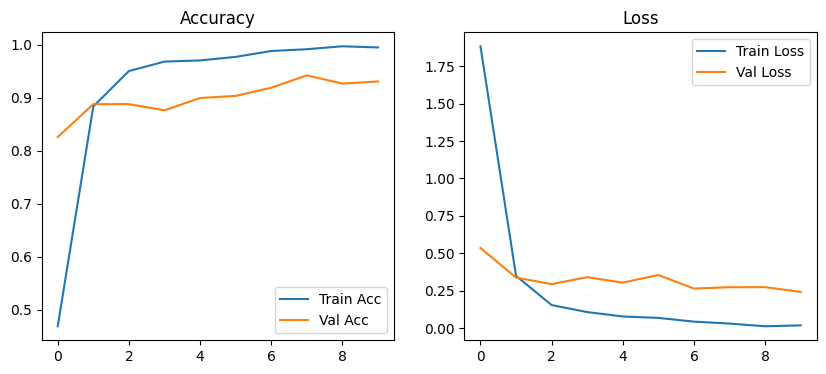

In [7]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['categorical_accuracy'], label='Train Acc')
plt.plot(history.history['val_categorical_accuracy'], label='Val Acc')
plt.title('Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss'); plt.legend()

plt.show()

In [8]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - categorical_accuracy: 0.8990 - loss: 0.4929
Test accuracy: 0.8984


### Results: Dropout

Compared to the pooling version, the dropout model reached a higher test accuracy of 89.84% (vs 88.28%) and showed smoother validation curves.

Training accuracy was slightly lower, but validation loss kept decreasing instead of rising after epoch 5, meaning the model generalized better.

The gap between training and validation became smaller, confirming that dropout reduced overfitting.

-----

### Next steps

Next, we will enable early stopping to stop training when validation loss stops improving and observe its effect on model stability.

-----

### References:
- https://medium.com/@vishnuam/dropout-in-convolutional-neural-networks-cnn-422a4a17da41